# Association rule mining

You will use:
* orders.csv
* order_products__prior.csv
* products.csv
* aisles.csv (optional but VERY powerful later)

### Step 1 — Merge the tables

In [2]:
import pandas as pd

orders = pd.read_csv("..\data_raw\orders.csv")
order_products = pd.read_csv("..\data_raw\order_products__prior.csv")
products = pd.read_csv("..\data_raw\products.csv")

# Merge product names
df = order_products.merge(products, on="product_id")

df.head()


<>:3: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:4: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:5: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:3: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:4: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:5: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
C:\Users\i025423\AppData\Local\Temp\ipykernel_6576\2970818263.py:3: SyntaxWarning:

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


### Step 2: Create baskets

We group products per order:

In [3]:
transactions = df.groupby('order_id')['product_name'].apply(list)
transactions.head()

order_id
2    [Organic Egg Whites, Michigan Organic Kale, Ga...
3    [Total 2% with Strawberry Lowfat Greek Straine...
4    [Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr...
5    [Bag of Organic Bananas, Just Crisp, Parmesan,...
6    [Cleanse, Dryer Sheets Geranium Scent, Clean D...
Name: product_name, dtype: object

### Step 3 — One-Hot Encoding (Basket Matrix)

Association algorithms need:

| order_id | Banana | Milk | Yogurt | Bread |
| -------- | ------ | ---- | ------ | ----- |
| 1        | 1      | 1    | 1      | 0     |
| 2        | 0      | 0    | 1      | 1     |
--------------------------------------------

We create it:


In [4]:
#import sys
#print(sys.executable)
#import sys
#!{sys.executable} -m pip install mlxtend

In [5]:
# because of the RAM error, I will delete rare products (90% of products are almost never bought)
product_counts = df['product_name'].value_counts()

popular_products = product_counts[product_counts > 2500].index

df_filtered = df[df['product_name'].isin(popular_products)]


In [6]:
# Limit commands :
# Instacart df contain the entire history of the cliens so we will consider only a sample
sample_orders = df_filtered['order_id'].drop_duplicates().sample(100000, random_state=42)

df_filtered = df_filtered[df_filtered['order_id'].isin(sample_orders)]

# Step 3: Recreate the trandactions DF
transactions = df_filtered.groupby('order_id')['product_name'].apply(list)


In [7]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

basket = pd.DataFrame(te_ary, columns=te.columns_)
basket.head()

,0% Fat Free Organic Milk,0% Greek Strained Yogurt,1 Liter,1 Ply Paper Towels,1% Low Fat Milk,1% Lowfat Milk,1% Milkfat Low Fat Buttermilk,100 Calorie Per Bag Popcorn,100% Apple Juice,100% Cranberry Juice,...,"Yogurt, Strained Low-Fat, Coconut",Yotoddler Organic Pear Spinach Mango Yogurt,Yukon Gold Potatoes 5lb Bag,ZBar Organic Chocolate Brownie Energy Snack,Zen Tea,Zero Calorie Cola,Zero Soda,of Hanover 100 Calorie Pretzels Mini,smartwater® Electrolyte Enhanced Water,with Crispy Almonds Cereal
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Association rules Explaination: 


Here are some key takes from the rules tables, to explain the meaning of each column:

* __🧠Support__: _support(A,B)_ = Frequency of occurrence of baskets containing both A and B.
    
    support = 0.02

    → 2% of baskets contains both products

    👉 Used to determine whether the rule is statistically reliable.

* __🧠Confidence__: _confidence(A→B) = P(B | A)_ When a customer buys A, what is the probability that they will also buy B?
    _Strawberries → Banana_
    _confidence = 0.68_ Means that 68% of clients who bought strawberry also bought banana
* __🧠Lift__: Actual dependence between products
    - lift = 1 → hasard (no link)
    - lift > 1 → linked products
    - lift > 2 → very strong realation shape

In [8]:

from mlxtend.frequent_patterns import apriori, association_rules

# itemsets fréquents
frequent_itemsets = apriori(
    basket,
    min_support=0.01,
    use_colnames=True
)

# règles d'association
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.2
)

rules.head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,frozenset({Organic Baby Spinach}),frozenset({Bag of Organic Bananas}),0.07884,0.12338,0.01665,0.211187,1.711681,1.0,0.006923,1.111316,0.451365,0.089724,0.100166,0.173068
1,frozenset({Bag of Organic Bananas}),frozenset({Organic Baby Spinach}),0.12338,0.07884,0.01665,0.134949,1.711681,1.0,0.006923,1.064862,0.474298,0.089724,0.060911,0.173068
2,frozenset({Organic Hass Avocado}),frozenset({Bag of Organic Bananas}),0.07029,0.12338,0.02032,0.289088,2.343071,1.0,0.011648,1.233092,0.616547,0.117219,0.189031,0.226891
3,frozenset({Bag of Organic Bananas}),frozenset({Organic Hass Avocado}),0.12338,0.07029,0.02032,0.164694,2.343071,1.0,0.011648,1.113018,0.653886,0.117219,0.101542,0.226891
4,frozenset({Organic Raspberries}),frozenset({Bag of Organic Bananas}),0.04485,0.12338,0.01355,0.302118,2.448680,1.0,0.008016,1.256115,0.619397,0.087600,0.203895,0.205971


In [9]:
#rules.columns

In [10]:
strong_rules = rules[
    (rules['confidence'] > 0.01) &
    (rules['lift'] > 1.8) &
    (rules['support'] > 0.01)
].sort_values(by='lift', ascending=False)

strong_rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
31,frozenset({Organic Raspberries}),frozenset({Organic Strawberries}),0.04485,0.08590,0.01182,0.263545,3.068046,1.0,0.007967,1.241217,0.705711,0.099386,0.194339,0.200574
30,frozenset({Organic Strawberries}),frozenset({Organic Raspberries}),0.08590,0.04485,0.01182,0.137602,3.068046,1.0,0.007967,1.107551,0.737403,0.099386,0.097107,0.200574
5,frozenset({Bag of Organic Bananas}),frozenset({Organic Raspberries}),0.12338,0.04485,0.01355,0.109823,2.448680,1.0,0.008016,1.072989,0.674884,0.087600,0.068024,0.205971
4,frozenset({Organic Raspberries}),frozenset({Bag of Organic Bananas}),0.04485,0.12338,0.01355,0.302118,2.448680,1.0,0.008016,1.256115,0.619397,0.087600,0.203895,0.205971
16,frozenset({Banana}),frozenset({Organic Fuji Apple}),0.15346,0.02814,0.01057,0.068878,2.447686,1.0,0.006252,1.043751,0.698669,0.061802,0.041917,0.222250
17,frozenset({Organic Fuji Apple}),frozenset({Banana}),0.02814,0.15346,0.01057,0.375622,2.447686,1.0,0.006252,1.355813,0.608576,0.061802,0.262435,0.222250
3,frozenset({Bag of Organic Bananas}),frozenset({Organic Hass Avocado}),0.12338,0.07029,0.02032,0.164694,2.343071,1.0,0.011648,1.113018,0.653886,0.117219,0.101542,0.226891
2,frozenset({Organic Hass Avocado}),frozenset({Bag of Organic Bananas}),0.07029,0.12338,0.02032,0.289088,2.343071,1.0,0.011648,1.233092,0.616547,0.117219,0.189031,0.226891
22,frozenset({Organic Avocado}),frozenset({Organic Baby Spinach}),0.05728,0.07884,0.01051,0.183485,2.327304,1.0,0.005994,1.128160,0.604971,0.083672,0.113601,0.158396
23,frozenset({Organic Baby Spinach}),frozenset({Organic Avocado}),0.07884,0.05728,0.01051,0.133308,2.327304,1.0,0.005994,1.087722,0.619130,0.083672,0.080647,0.158396


In [11]:
def recommend(product_name, rules, top_n=5):

    recs = rules[rules['antecedents'].apply(lambda x: product_name in x)]

    recs = recs.sort_values('lift', ascending=False)

    return recs[['consequents','confidence','lift']].head(top_n)

recommend('Organic Baby Spinach', rules)

,consequents,confidence,lift
23,frozenset({Organic Avocado}),0.133308,2.327304
25,frozenset({Organic Hass Avocado}),0.146880,2.089625
27,frozenset({Organic Strawberries}),0.158422,1.844262
0,frozenset({Bag of Organic Bananas}),0.211187,1.711681
15,frozenset({Banana}),0.207002,1.348896


<h4 style="color:white; background-color:DodgerBlue;border-color:Black!;border-left:6px solid #ccc"> Make Recommendation </h4>

<p> Here we ask the system, When a customer buys <strong>Organic Baby Spinach</strong>, what should we recommend next?

The function searches all the rules : <i>Organic Baby Spinach -> ?</i> and return all the best consequents (recommended products). 

We use three key metrics for this:

<strong style="color:MediumSeaGreen">Confidence</strong>
confidence = probability customer buys B IF they bought Organic Baby Spinach

Example : 

confidence = 0.21 --> <span style="color:Orange">21%</span> <span style="color:Grey">of the spinach buyers also bye Bag od Organic Banana</span>

<strong style="color:MediumSeaGreen">Lift</strong>

<span style="color:Orange">Lift</span> = how much more likely compared to a random shopper
<ul style="background: #f9f9f9;
        margin-bottom: 8px;
        padding: 12px 20px;
        border-left: 5px solid #007bff; /* Accent color */
        border-radius: 4px;
        transition: transform 0.2s; /* Smooth animation */">
<li>lift = 1 → coincidence</li>
<li>lift > 1.5 → meaningful</li>
<li>lift > 2 → strong behavioral link</li>
</ul>

This is the real “intelligence” of the recommender.

Now, let's interpret each recommendation:

<h5>1. Organic Avocado:</h5>

<img src="../images/organic-avocado.jpg" alt="organic-avocado" width="500" height="300">

<span style="color:Orange">confidence: 0.133</span>
<br>
<span style="color:Orange">lift: 2.32</span>

<strong>
<span style="color: #ff5733; margin-right: 10px;">🔵</span>
Meaning</strong>

<strong style="color: #987826; background-color: #c9f1ef">13.3% of people who buy spinach also buy organic avocado.</strong>

But the crucial part:

They are <strong style="color: #e92323; background-color: #eaeeed">2.32×</strong> more likely than an average customer to buy avocado.

This is a very strong association.

<stong>Behavioral interpretation</strong>

This screams:
<ul style="list-style: none; padding-left: 5px;">
<li style="margin-bottom: 8px;">
<span style="color: #ff5733; margin-right: 10px;">🚀</span>
salad preparation</li>
<li style="margin-bottom: 8px;">
<span style="color: #ff5733; margin-right: 10px;">🚀</span>
healthy bowl
</li>
<li style="margin-bottom: 8px;">
<span style="color: #ff5733; margin-right: 10px;">🚀</span>
vegetarian meal
</li>
<li style="margin-bottom: 8px;">
<span style="color: #ff5733; margin-right: 10px;">🚀</span>
smoothie
</li>
</ul>
This is not random shopping. It is intentional cooking.

<strong> <span style="color: #ff5733; margin-right: 10px;"> 🎯</span> Business action</strong>

When a user adds spinach to cart:

Show:

“Add Organic Avocado — perfect for salads & smoothies”. This is a high-quality recommendation.

<h5> 2. Organic Hass Avocado </h5>
<img src="../images/organic-hass-avocado.webp" alt="organic hass avocado" width="500" height="300"> <br>
<span style="color:Orange">confidence: 0.147</span><br>
<span style="color:Orange">lift: 2.08</span><br>

Here we discover something deeper, Customer care about Avocado type, This suggests: 
<ul style="background: #f9f9f9;
        margin-bottom: 8px;
        padding: 12px 20px;
        border-left: 5px solid #007bff; /* Accent color */
        border-radius: 4px;
        transition: transform 0.2s; /* Smooth animation */">
<li>quality-conscious buyers</li>
<li>organic preference</li>
<li>premium basket segment</li>
</ul>
This is what we call: <strong>a high-value customer segment</strong>, which usually have higher basket value.
<h5> 3. Organic Strawberries </h5>
<img src="../images/strawberry-shortcake.png" alt="Strawberry shortcake"> <br>
<span style="color:Orange">confidence: 0.158</span><br>
<span style="color:Orange">lift: 1.84</span><br>

Now the pictures become clearer: Spinach + Avocado + Strawberries, which is extremly typical for: Smoothie preparation
<strong>Business implication</strong>

Retailer could create : "Smoothie Starter Pack" with : spinach, strawberries, banana, avocado.

<h5> 4. Bag of Organic Banana </h5>
<img src="../images/organic-banana.jpg" alt="Organic banana bag"> <br>
<span style="color:Orange">confidence: 0.211</span><br>
<span style="color:Orange">lift: 1.71</span><br>

<strong style="color: #987826; background-color: #c9f1ef">%21</strong> of spinach buyers also buy organic banana. Banana appears again because it is a: <strong>complementary base ingredient</strong>. Banana us used to: 
<ul style="background: #f9f9f9;
        margin-bottom: 8px;
        padding: 12px 20px;
        border-left: 5px solid #007bff; /* Accent color */
        border-radius: 4px;
        transition: transform 0.2s; /* Smooth animation */">
<li>Soften smoothies</li>
<li>Add sweetness</li>
<li>Combine with greens</li>
</ul>

Banana is acting as a <strong>complementary product</strong>, not just a popular product here (lift > 1 confirms it's not coincidence).

<h5> 5. Banana </h5>
<img src="../images/banana.webp" alt="Yellow banana with a friendly face on white background"> <br>
<span style="color:Orange">confidence: 0.207</span><br>
<span style="color:Orange">lift: 1.35</span><br>

Slightly weaker, but still meaningful.

<strong> <span style="color: #ff5733; margin-right: 10px;">🔥</span> Important insight:</strong>

Customers who buy spinach: prefer organic bananas (higher lift) but still sometimes buy regular bananashis suggests a mixed purchasing behavior: “health-leaning but not strictly organic”. That’s actually a <i>realistic consumer profile</i>.

</p>

In [12]:
#!pip install networkx

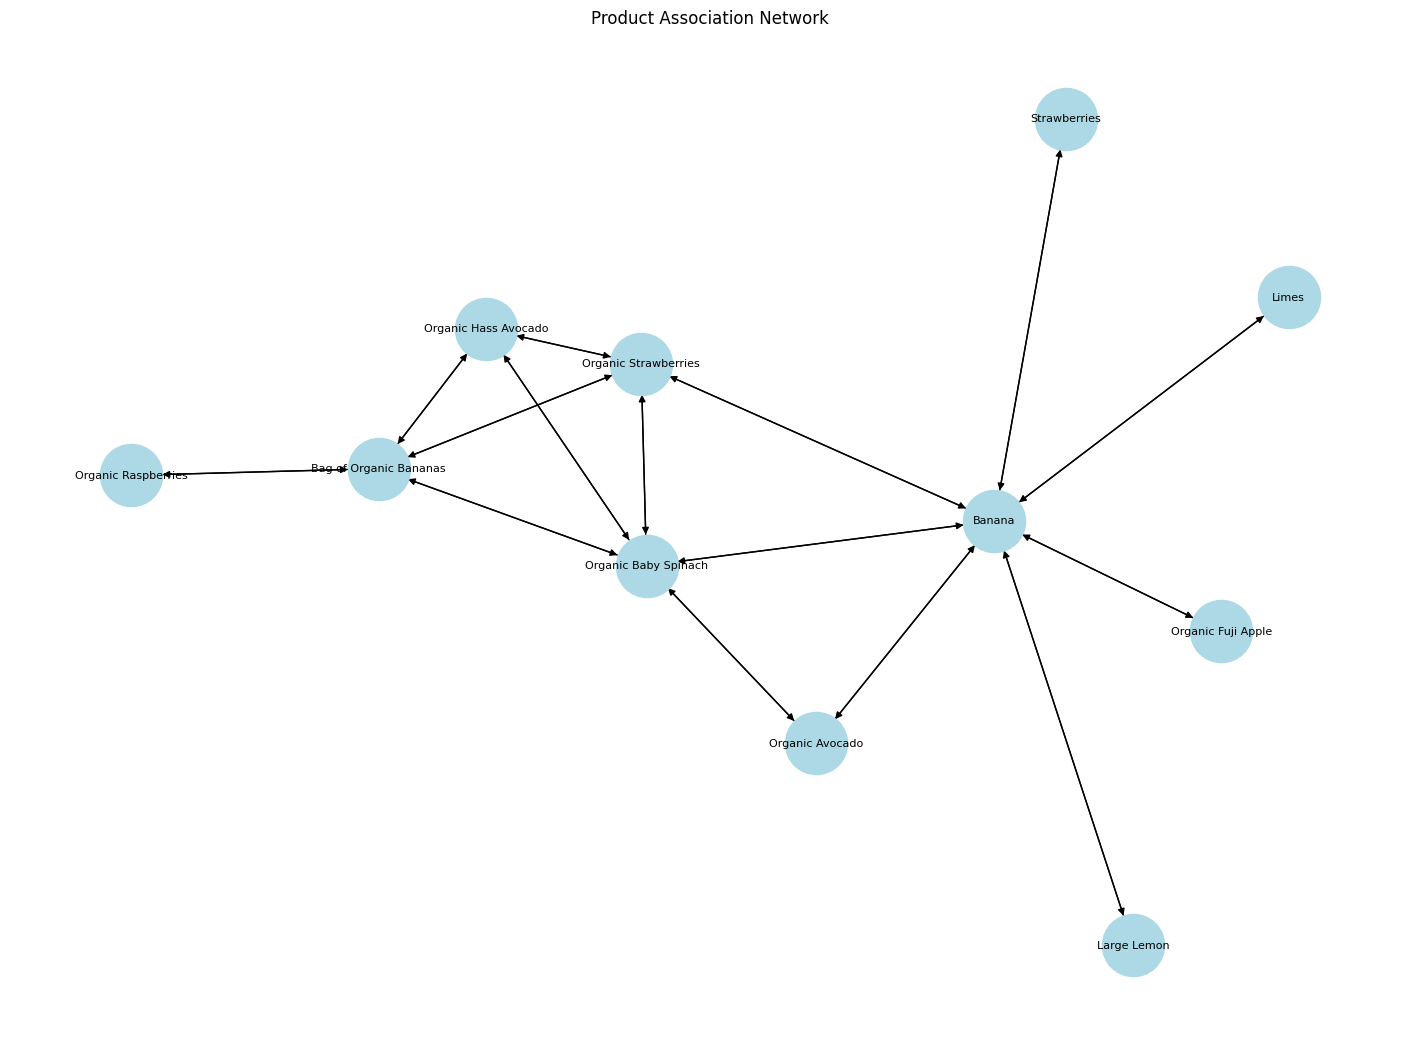

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for _, row in rules.head(30).iterrows():
    for a in row['antecedents']:
        for b in row['consequents']:
            G.add_edge(a, b, weight=row['lift'])

plt.figure(figsize=(14,10))
pos = nx.spring_layout(G, k=0.6)

nx.draw(G, pos,
        with_labels=True,
        node_size=2000,
        node_color="lightblue",
        font_size=8,
        arrows=True)

plt.title("Product Association Network")
plt.show()


<h4> Results and interpretations </h4>

<h5 style="background-color: lightgrey; color: red; font-family: Arial;">1- How to read the graph?</h5>

This graph represents a "supermarket mental map". 

* Each node = a product. (A-->B means customers who buy A are likely to also buy B).
* Each arrow = a behavioral relationship.
* The closer products appear --> the more they belong to the same consumption context.

Here we did not cluster customer, we clustered __meals and lifestyles__.

<<h5 style="background-color: lightgrey; color: red; font-family: Arial;">2- The most important node</h5>

In this graph "Banana" product represents a __"Basket Anchor Product"__ which is an item purchased by a very large number of customers and that triggers other purchases. 

From this graph we have: 

- Banana -> Organic Avocado
- Banana -> Organic Fuji Apple
- Banana -> Strawberries

__Banana__ is not just popular. It predicts _fruit basket contruction_. 

__Banana__ is a traffic generator product. Which means a any discount applied to Bananas will pull other items from this list into the basket.

<h5 style="background-color: lightgrey; color: red; font-family: Arial;"> 3- The <strong>"Healthy Lifestyle Cluster"</strong></h5>

<p>Let's look at this group: </p>

<ul style="background: #f9f9f9;
        margin-bottom: 8px;
        padding: 12px 20px;
        border-left: 5px solid #007bff; /* Accent color */
        border-radius: 4px;
        transition: transform 0.2s; /* Smooth animation */">
<li> Organic Hass Avocado</li>
<li> Organic Baby Spinach</li>
<li> Organic Strawberries</li>
<li> Organic Raspberries</li>
<li> Organic Bananas</li>
</ul>
This is extremly important as we discovered a behavioral segment without using customer demographics. These products correspond to: Smoothies, salads, diet/fitness consumption and plant-based eating. 

This can help us: Personalize homepage, recommend recipes, target ads. 

<h5 style="background-color: lightgrey; color: red; font-family: Arial;"> 4- The <strong>"Avocado chain"</strong> (very intersting)</h5>

We have the following chain: 

Banana → Avocado → Spinach → Strawberries → Raspberries

Represents a meal preparation pattern. very likely behavior "smoothie preparation", the algorithm just discoverd a recipe from raw data. 

<h5 style="background-color: lightgrey; color: red; font-family: Arial;"> 5- The difference between popularity and dependency </h5>

Banana appears everywhere because it is popular, but Organic Baby Spinach linking to Avocado
is more interesting. Spinach is not a mass product, so when it appears it strongly predict a specific consumption intention. Which makes Spinach not a frequent product — but a “purpose-driven” product.

<h2> Eclat Algorithm</h2>

<h3>1️⃣. Install the library</h3>
To use The Eclat algorithm we need to install its library using: 
<code>pip install pyECLAT</code>

<h3>2️⃣. Preapare the data</h3>
<p>
<strong>Eclat</strong> expect a dataframe where each row = one transaction. 
Rightnow our `transaction` looks like:

<img src="../images/transactions.png" alt = "Transactions Dataframe">

We will convert it to something like this: 
<table style="border-collapse: collapse; margin: 25px 0; font-size: 0.9em; font-family: sans-serif;min-width: 400px; box-shadow: 0 0 20px rgba(0, 0, 0, 0.1); border-radius: 5px 5px 0 0; overflow: hidden;">
    <thead>
        <tr style = "background-color: #009879; color: #ffffff; text-align: left; font-weight: bold;">
            <th style = "padding: 12px 15px;">0</th>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Banana</td>
            <td>Yogurt</td>
            <td>Milk</td>
            <td>NaN</td>
        </tr>
        <tr>
            <td>Spinach</td>
            <td>Avocado</td>
            <td>NaN</td>
            <td>NaN</td>
        </tr>
        <tr>
            <td>Strawberry</td>
            <td>Banana</td>
            <td>Spinach</td>
            <td>Avocado</td>
        </tr>
    </tbody>
</table>

This is exactly what Eclat needs.
</p>

In [15]:
transactions_list = transactions.tolist()
transactions_df = pd.DataFrame(transactions_list)
transactions_df.head()


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,Cereal,French Onion Dip,Chicken Pot Pie,Presliced Everything Bagels,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tilapia Filet,Organic Lactose Free Whole Milk,XL Emerald White Seedless Grapes,Limes,Organic Avocado,No Salt Added Black Beans,Jalapeno Peppers,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Baby Spinach Salad,Sliced Baby Bella Mushrooms,Unsweetened Almondmilk,Organic Hass Avocado,Organic Acorn Squash,Organic English Cucumber,Organic Strawberries,Organic Kiwi,Brussels Sprouts,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bag of Organic Bananas,Organic Vanilla Almond Milk,Large Pineapple Chunks,Raspberries,Crackers Cheddar Bunnies Snack Packs,"Juice Beverage, Cold Pressed, Kale Apple Ginge...",Toasted Coconut Chips Original Recipe,Yellow Onions,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Goodness Grapeness Organic Juice Drink,Organic Baby Spinach,Wild Berry Smoothie,Organic Jasmine Rice,Sea Salt Potato Chips,Organic Beef Hot Dogs,Buttermilk Biscuits,Organic Vanilla Almond Milk,Organic Yellow Mustard,Chopped Onions,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<h3>2️⃣. Run Eclat</h3>

In [ ]:
from pyECLAT import ECLAT

eclat = ECLAT(data=transactions_df)


In [17]:
# Now we mine frequent itemsets:
indices, support = eclat.fit(min_support=0.01,
                             min_combination=2,
                             max_combination=2)

Combination 2 by 2


5778it [15:58,  6.03it/s]


<div style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; 
            max-width: 600px; 
            margin: 20px 0; 
            border: 1px solid #e1e4e8; 
            border-radius: 8px; 
            overflow: hidden; 
            box-shadow: 0 4px 6px rgba(0,0,0,0.05);">
    
<div style="background-color: #6096cc; color: white; padding: 15px 20px; font-size: 1.1em; font-weight: bold;">
        ⚙️ Association Rule Parameters
</div>

<div style="background-color: #ffffff; padding: 10px 0;">
        
<div style="display: flex; align-items: center; padding: 12px 20px; border-bottom: 1px solid #f0f2f5;">
<code style="background: #f1f3f5; color: #d63384; padding: 4px 8px; border-radius: 4px; font-weight: bold; min-width: 160px;">min_support=0.01</code>
<span style="margin-left: 15px; color: #4a5568;">➜ Appears in at least <b>1%</b> of baskets</span>
</div>

<div style="display: flex; align-items: center; padding: 12px 20px; border-bottom: 1px solid #f0f2f5;">
<code style="background: #f1f3f5; color: #d63384; padding: 4px 8px; border-radius: 4px; font-weight: bold; min-width: 160px;">min_combination=2</code>
<span style="margin-left: 15px; color: #4a5568;">➜ Analyzes <b>pairs</b> only</span>
</div>

<div style="display: flex; align-items: center; padding: 12px 20px;">
            <div style="display: flex; flex-direction: column;">
                <div style="display: flex; align-items: center;">
                    <code style="background: #f1f3f5; color: #d63384; padding: 4px 8px; border-radius: 4px; font-weight: bold; min-width: 160px;">max_combination=2</code>
                    <span style="margin-left: 15px; color: #4a5568;">➜ Avoids <b>memory explosion</b></span>
                </div>
                <div style="margin-left: 175px; margin-top: 5px; font-size: 0.85em; color: #e74c3c; font-style: italic; font-weight: bold;">
                    ⚠️ Highly Important for Performance
                </div>
            </div>
        </div>
</div>
</div>
<h3> 4️⃣ Explore the results </h3>

In [18]:
support

{'Organic Hass Avocado & Organic Strawberries': 0.01343,
 'Organic Hass Avocado & Bag of Organic Bananas': 0.02032,
 'Organic Hass Avocado & Banana': 0.01033,
 'Organic Hass Avocado & Organic Baby Spinach': 0.01158,
 'Strawberries & Banana': 0.01348,
 'Organic Avocado & Banana': 0.01722,
 'Organic Avocado & Organic Baby Spinach': 0.01051,
 'Organic Raspberries & Organic Strawberries': 0.01182,
 'Organic Raspberries & Bag of Organic Bananas': 0.01355,
 'Organic Strawberries & Bag of Organic Bananas': 0.02017,
 'Organic Strawberries & Banana': 0.01836,
 'Organic Strawberries & Organic Baby Spinach': 0.01249,
 'Limes & Banana': 0.01034,
 'Bag of Organic Bananas & Organic Baby Spinach': 0.01665,
 'Large Lemon & Banana': 0.01255,
 'Banana & Organic Fuji Apple': 0.01057,
 'Banana & Organic Baby Spinach': 0.01632}

<h3>5️⃣. Convert Eclat output into rules (this is the missing step)</h3>
<p>
We now compute confidence manually.

Example:

$$Confidence(\text{Spinach} \rightarrow \text{Avocado}) = \frac{Support(\text{Spinach} \cap \text{Avocado})}{Support(\text{Spinach})}$$

$$Confidence = \frac{0.014}{0.06} = 0.2333... \approx 23.3\%$$

To construct this equation, we need to code it with python:

1. we compute individual supports:
</p>


In [19]:
single_support = eclat.fit(min_support=0.01,
                           min_combination=1,
                           max_combination=1)[1]


Combination 1 by 1


108it [01:06,  1.62it/s]


2. We Calculate confidence:

In [27]:
rules = []

for items, sup in support.items():
    products = items.split(" & ")

    # only keep pairs
    if len(products) == 2:
        A, B = products
        # A -> B
        if A in single_support:
            conf_AB = sup / single_support[A]
            rules.append((A, B, sup, conf_AB))

        # B -> A
        if B in single_support:
            conf_BA = sup / single_support[B]
            rules.append((B, A, sup, conf_BA))


rules_df = pd.DataFrame(rules, columns=['A','B','support','confidence'])
rules_df.sort_values('confidence', ascending=False).head(10)

,A,B,support,confidence
31,Organic Fuji Apple,Banana,0.01057,0.375622
16,Organic Raspberries,Bag of Organic Bananas,0.01355,0.302118
10,Organic Avocado,Banana,0.01722,0.300628
8,Strawberries,Banana,0.01348,0.292789
2,Organic Hass Avocado,Bag of Organic Bananas,0.02032,0.289088
14,Organic Raspberries,Organic Strawberries,0.01182,0.263545
28,Large Lemon,Banana,0.01255,0.259351
18,Organic Strawberries,Bag of Organic Bananas,0.02017,0.234808
24,Limes,Banana,0.01034,0.228609
20,Organic Strawberries,Banana,0.01836,0.213737


<div style="font-family: 'Segoe UI', Arial, sans-serif; color: #2c3e50; line-height: 1.6; max-width: 800px; margin: auto; padding: 20px; border: 1px solid #e1e4e8; border-radius: 15px; background-color: #ffffff;">

<div style="background: linear-gradient(135deg, #2c3e50 0%, #34495e 100%); color: white; padding: 25px; border-radius: 12px; margin-bottom: 30px; box-shadow: 0 4px 15px rgba(0,0,0,0.1);">
    <h2 style="margin: 0; font-size: 24px; letter-spacing: 1px;">📊 Results and Implications</h2>
    <p style="margin: 10px 0 0 0; opacity: 0.9; font-size: 0.95em;">Market Basket Analysis & Consumer Behavioral Study</p>
</div>

<div style="background-color: #f8f9fa; border-left: 5px solid #007bff; padding: 20px; margin-bottom: 30px; border-radius: 0 8px 8px 0;">
    <h4 style="margin-top: 0; color: #007bff;">Metric Key</h4>
    <p>Before diving into the results, here is how to read our association rules (<strong>A → B</strong>):</p>
    <ul style="list-style: none; padding-left: 0;">
        <li style="margin-bottom: 10px;">
            <span style="background: #007bff; color: white; padding: 2px 8px; border-radius: 4px; font-family: monospace;">confidence</span> 
            ➜ Probability of buying <b>B</b> when <b>A</b> is purchased.
        </li>
        <li style="margin-bottom: 10px;">
            <span style="background: #6c757d; color: white; padding: 2px 8px; border-radius: 4px; font-family: monospace;">support</span> 
            ➜ How often this pair appears across <b>ALL</b> transactions.
        </li>
    </ul>
    <div style="margin-top: 15px; padding: 10px; background: white; border-radius: 6px; border: 1px dashed #007bff;">
        <strong style="color: #d63384;">Example:</strong> Organic Fuji Apple → Banana (Confidence: <b>0.375</b>)<br>
        <small><i>Interpretation: 37.5% of Fuji Apple buyers also buy Bananas. (Retail Benchmark: >20% is strong).</i></small>
    </div>
</div>

<h3 style="border-bottom: 2px solid #eee; padding-bottom: 10px; color: #2c3e50;">💡 Strategic Insights</h3>
<p>We have grouped the data into <strong>3 core consumption patterns</strong>.</p>

<div style="margin-bottom: 40px; border: 1px solid #e1e4e8; border-radius: 12px; overflow: hidden;">
    <div style="background-color: #e8f5e9; padding: 15px 20px; border-bottom: 1px solid #e1e4e8;">
        <strong style="color: #2e7d32; font-size: 1.1em;">🟢 Pattern 1: The Fruit Basket (Base Signal)</strong>
    </div>
    <div style="padding: 20px;">
        <div style="display: flex; gap: 20px; flex-wrap: wrap;">
            <div style="flex: 1; min-width: 250px;">
                <span style="text-transform: uppercase; font-size: 0.75em; font-weight: bold; color: #95a5a6;">Rules Identified:</span>
                <ul style="list-style-type: '🚀 '; padding-left: 20px; color: #34495e; font-size: 0.9em;">
                    <li>Organic Fuji Apple → Banana</li>
                    <li>Strawberries → Banana</li>
                    <li>Large Lemon → Banana</li>
                    <li>Organic Raspberries → Bag of Organic Bananas</li>
                </ul>
            </div>
            <div style="flex: 1; min-width: 250px; background: #fffde7; padding: 15px; border-radius: 8px;">
                <strong style="display: block; margin-bottom: 5px;">🧠 Interpretation: "The Basket Builder"</strong>
                Banana is a <i>completion product</i>. Customers choose their primary fruit first, then add bananas because they are cheap, filling, and versatile.
            </div>
        </div>
        
<div style="margin-top: 20px;">
            <strong style="color: #d35400;">⚡ Business Actions:</strong>
            <div style="display: flex; gap: 10px; margin-top: 10px;">
                <div style="flex: 1; background: #fdf2f2; padding: 10px; border-radius: 6px; font-size: 0.85em; border: 1px solid #feb2b2;"><b>1. Recommend:</b> Suggest bananas instantly when berries are added to cart.</div>
                <div style="flex: 1; background: #fdf2f2; padding: 10px; border-radius: 6px; font-size: 0.85em; border: 1px solid #feb2b2;"><b>2. Pricing:</b> Don't discount bananas; use "Buy 2 Fruits, Get Banana Discount" to grow basket size.</div>
            </div>
        </div>
    </div>
</div>

<div style="margin-bottom: 40px; border: 1px solid #e1e4e8; border-radius: 12px; overflow: hidden;">
    <div style="background-color: #e3f2fd; padding: 15px 20px; border-bottom: 1px solid #e1e4e8;">
        <strong style="color: #1565c0; font-size: 1.1em;">🔵 Pattern 2: Smoothie / Healthy Eating Mission</strong>
    </div>
    <div style="padding: 20px;">
        <p>Our algorithm reverse-engineered a <b>recipe</b> from anonymous data. This is planned meal behavior.</p>
        <div style="background: #f1f8ff; padding: 15px; border-radius: 8px; border: 1px solid #c8e1ff; margin-bottom: 15px;">
            <span style="font-weight: bold; color: #0366d6;">🥤 The "Smoothie Kit" Opportunity:</span><br>
            Bundling <i>Raspberries + Avocado + Banana</i> increases basket value because these customers already intend to buy the set.
        </div>
        <ul style="list-style-type: '✅ '; padding-left: 20px; font-size: 0.9em;">
            <li>Organic Raspberries → Organic Strawberries</li>
            <li>Organic Hass Avocado → Bag of Organic Bananas</li>
        </ul>
    </div>
</div>

<div style="border: 1px solid #e1e4e8; border-radius: 12px; overflow: hidden; background: #fafafa;">
    <div style="background-color: #fff3e0; padding: 15px 20px; border-bottom: 1px solid #e1e4e8;">
        <strong style="color: #ef6c00; font-size: 1.1em;">🟠 Pattern 3: Citrus & Flavor Complementarity</strong>
    </div>
    <div style="padding: 20px;">
        <p>Customers buying <strong>Limes, Lemons and Banana</strong> Citrus fruits rarely eaten alone they are preparing specific recipes (drinks, salads, marinades).
        <div style="background: #fff3e0; padding: 15px; border-radius: 8px; border: 1px solid #c8e1ff; margin-bottom: 15px;">
        <span>Banana appears again because they’re shopping for multiple meal occasions at once.</span>
        </div>
        </p>
        <blockquote style="border-left: 4px solid #ff9800; margin: 0; padding-left: 15px; font-style: italic; color: #555;">
            "Customers don't shop per product. They shop per meal plan."
        </blockquote>
    </div>
</div>
</div>